In [ ]:
import numpy as np  
#import pandas as pd
import matplotlib.pyplot as plt
import PIL
import PIL.Image
import glob
import cv2
import os
import seaborn as sns
import tensorflow as tf
import keras
import xgboost as xgb
#import shutil

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.applications.vgg16 import VGG16

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
# Read input images and assign labels based on folder names
print(os.listdir("C:\\Users\Administrator\Desktop\Cacao V4 model\Cacao V4 dataset/"))

SIZE = 256  #Resize images

#Capture training data and labels into respective lists
train_images = []
train_labels = [] 

for directory_path in glob.glob("C:\\Users\Administrator\Desktop\Cacao V4 model\Cacao V4 dataset/train/*"):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)
        
#Convert lists to arrays        
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [ ]:
# Capture test/validation data and labels into respective lists

test_images = []
test_labels = [] 
for directory_path in glob.glob("C:\\Users\Administrator\Desktop\Cacao V4 model\Cacao V4 dataset/val/*"):
    fruit_label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(fruit_label)

#Convert lists to arrays                
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [ ]:
#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [ ]:
#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [ ]:
# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

In [ ]:
#Load model wothout classifier/fully connected layers
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

In [ ]:
#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False
    
VGG_model.summary()  #Trainable parameters will be 0

In [ ]:
#Now, let us use features from convolutional network for RF
feature_extractor=VGG_model.predict(x_train)

In [ ]:
features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_training = features #This is our X input to RF


In [ ]:
#XGBOOST
model = xgb.XGBClassifier(eval_metric='mlogloss')
model.fit(X_for_training, y_train) #For sklearn no one hot encoding


In [ ]:
#Send test data through same feature extractor process
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

In [ ]:
#Now predict using the trained RF model. 
prediction = model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction = le.inverse_transform(prediction)

In [ ]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction))

In [ ]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, prediction)
#print(cm)
sns.heatmap(cm, annot=True)

In [ ]:
import pickle

with open('V4model_pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
with open('V4model_pkl', 'rb') as f:
    model = pickle.load(f)

The prediction for this image is:  ['healthy']
The actual label for this image is:  pod_borer


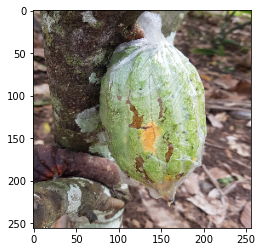

In [193]:
#Check results on a test images
n=np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)

#input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
#input_img_feature=VGG_model.predict(input_img)

#input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)

#prediction = model.predict(input_img_features)[0] 

#prediction = le.inverse_transform([prediction])  #Reverse the label encoder to original name

print("The prediction for this image is: ", prediction)

print("The actual label for this image is: ", test_labels[n])
